In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from IPython.display import Markdown, display, HTML

In [82]:
import tiktoken


def count_tokens(string: str, model: str = "gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Pydantic
"Pydantic is like a super toy inspector. It checks your toys to make sure they are exactly what they should be, like making sure all cars are really cars and not broken. This helps keep your toy box organized so you can play without problems. In the same way, Pydantic helps programmers check and organize their data to make sure everything works correctly." - _gpt-4o: Explain pydantic to a 5yo_

In [2]:
from typing import Optional
from pydantic import BaseModel
from datetime import datetime


class LegalCase(BaseModel):
    case_id: str
    matter_name: str
    start_date: datetime
    # Optional means the value can be None
    # It is the equivalent of Union[bool, None]
    is_open: Optional[bool] = None
    # Optional can also be written like this in python 3.10+, where '|' is shorthand for Union
    # is_open: bool | None = None

In [3]:
case = LegalCase(
    case_id='01234567',
    matter_name="Limu vs. Douglas",
    start_date=datetime(2024, 1, 1),
    is_open='true',
)

case.model_dump()

{'case_id': '01234567',
 'matter_name': 'Limu vs. Douglas',
 'start_date': datetime.datetime(2024, 1, 1, 0, 0),
 'is_open': True}

In [4]:
pd.DataFrame([case.model_dump()])

,case_id,matter_name,start_date,is_open
0,01234567,Limu vs. Douglas,2024-01-01,True


In [5]:
case = LegalCase(
    case_id='01234567',
    matter_name="Limu vs. Douglas",
    start_date='2024-01-01',
    is_open='true',
)

pd.DataFrame([case.model_dump()])

,case_id,matter_name,start_date,is_open
0,01234567,Limu vs. Douglas,2024-01-01,True


In [6]:
case = LegalCase(
    case_id='01234567',
    matter_name="Limu vs. Douglas",
    start_date='01/01/2024',
    is_open='true',
)

ValidationError: 1 validation error for LegalCase
start_date
  Input should be a valid datetime or date, invalid character in year [type=datetime_from_date_parsing, input_value='01/01/2024', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/datetime_from_date_parsing

In [7]:
from pydantic import Field, field_validator


class LegalCase(BaseModel):
    case_id: str = Field(
        default=...,
        description="Unique id for the case."
    )
    matter_name: str = Field(
        default=...,
        description="The name of the case."
    )
    start_date: datetime = Field(
        default=...,
        description="The date the matter was first registered.",
        alias="earliest_matter_start_date",
    )
    is_open: bool | None = Field(
        default=None,
        description="Whether the case is open at the time of this record.",
    )
    
    @field_validator('start_date', mode='before')
    def parse_date(cls, value):
        # If value is already a datetime, return it directly
        if isinstance(value, datetime):
            return value
        # If value is a string, try to parse it with pandas
        if isinstance(value, str):
            try:
                return pd.to_datetime(value).to_pydatetime()
            except Exception as e:
                raise ValueError(f"Cannot parse date from string: {value}") from e
        # If value is a pandas Timestamp, convert it to datetime
        if isinstance(value, pd.Timestamp):
            return value.to_pydatetime()
        # Raise an error for unsupported types
        raise TypeError(f"Unsupported date type: {type(value)}")

In [8]:
date_options = [
    "01/01/2024",
    "2024-01-01T01:00:00Z",
    "2024-01-01 01:00:00",
    datetime(2024, 1, 1, 1, 0, 0)
]

results = []

for date in date_options:
    case = LegalCase(
        case_id='01234567',
        matter_name="Limu vs. Douglas",
        earliest_matter_start_date=date,
        is_open='true',
    )
    results.append(case.model_dump())

pd.DataFrame(results)

,case_id,matter_name,start_date,is_open
0,01234567,Limu vs. Douglas,2024-01-01 00:00:00,True
1,01234567,Limu vs. Douglas,2024-01-01 01:00:00+00:00,True
2,01234567,Limu vs. Douglas,2024-01-01 01:00:00,True
3,01234567,Limu vs. Douglas,2024-01-01 01:00:00,True


In [9]:
import hashlib
from typing import Any
from typing_extensions import Annotated
from uuid import uuid4
from pydantic import BeforeValidator, ConfigDict, model_validator


def parse_date(v: str) -> datetime.date:
    # If value is already a datetime, return its date
    if isinstance(v, datetime):
        return v.date()
    # If value is a string, try to parse it with pandas
    if isinstance(v, str):
        try:
            return pd.to_datetime(v).date()
        except Exception as e:
            raise ValueError(f"Cannot parse date from string: {v}") from e
    # If value is a pandas Timestamp, convert it to date
    if isinstance(v, pd.Timestamp):
        return v.date()
    # Raise an error for unsupported types
    raise TypeError(f"Unsupported date type: {type(v)}")
 

def normalize_case_id(v: str | int) -> str:
    # Convert to string if v is an int
    if isinstance(v, int):
        v = str(v) 
    # Remove any suffix (characters after a hyphen)
    v = v.split('-')[0]
    # Remove any non-digit characters
    v = ''.join(filter(str.isdigit, v))
    # Ensure the string is 9 characters long and starts with '0'
    if len(v) > 9:
        v = v[-9:]
    elif len(v) < 9:
        v = v.zfill(9)
    if not v.startswith('0'):
        v = '0' + v[1:]
    # Final check to ensure the result is valid
    if len(v) != 9 or not v.startswith('0'):
        raise ValueError(f"Unable to normalize case id: {v}")
    return v


class LegalCase(BaseModel):
    case_id: Annotated[str, BeforeValidator(normalize_case_id)] = Field(
        ...,
        description="Unique id for the case.",
    )
    matter_name: str = Field(
        ...,
        description="The name of the case.",
    )
    start_date: Annotated[datetime, BeforeValidator(parse_date)] = Field(
        ...,
        description="The date the matter was first registered.",
        alias="earliest_matter_start_date",
    )
    is_open: bool | None = Field(
        None,
        description="Whether the case is open at the time of this record.",
    )
    timestamp: datetime | str | None = Field(
        None,
        description="Timestamps for when the model was populated.",
    )
    id: str = Field(
        default_factory=lambda: uuid4().hex,
        description="A generated unique ID for the data model instance.",
    )
    hash_id: str | None = Field(
        None,
        description="Unique ID based on a hash of the case id and name.",
    )
    
    model_config = ConfigDict(
        # Allows additional attributes to be added when populating the model. Default is to 'ignore'.
        extra='allow',
        # To accept either the attribute name or the alias when populating
        populate_by_name=True,
    )
    # Model validators can access any value in the data model and perform operations on it
    # This is useful for creating new features and embedding the logic into model validation
    @model_validator(mode="before")
    def generate_tiemstamp(cls, values: Any) -> Any:
        timestamp = datetime.now()
        values['timestamp'] = timestamp.isoformat(timespec='minutes')
        return values
    
    @model_validator(mode="before")
    def generate_name(cls, values):
        unique_string = str(values["case_id"])+str(values["matter_name"])
        values['hash_id'] = hashlib.md5(unique_string.encode()).hexdigest()
        return values
    
    @property
    def to_pandas(self):
        return pd.DataFrame([self.model_dump()])
        

In [10]:
date_options = [
    "01/01/2024",
    "2024-01-01T01:00:00Z",
    "2024-01-01 01:00:00",
    datetime(2024, 1, 1, 1, 0, 0)
]

case_id_options = [
    1234567,
    "01234567",
    "01234567-01",
    "0001234567",
]

options = zip(case_id_options, date_options)

results = []

for id, date in options:
    case_name = "Limu vs. Douglas"
    case = LegalCase(
        case_id=id,
        matter_name=case_name,
        earliest_matter_start_date=date,
        # Omit the is_open optional value
        # is_open='true',
        # Add a new attribute just to illustrate
        new_name=f"{case_name} - {str(id)}"
    )
    results.append(case.to_pandas)
    
df = pd.concat(results, ignore_index=True)
df

,case_id,matter_name,start_date,is_open,timestamp,id,hash_id,new_name
0,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,5d0830824e654d79b96a54a425dd402d,4a615964633d38197e62391f00b826d5,Limu vs. Douglas - 1234567
1,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,423517b156184b1a813365a2cb88f599,6ce27cb314c6a8d0a77e2ca46686bcad,Limu vs. Douglas - 01234567
2,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,2a4cc1d735bc4af6aa6b58beafe8d8c6,86569bd750e2f8841ecc9be28b9daef8,Limu vs. Douglas - 01234567-01
3,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,57edb4252a2244ff9007c1ee25d91e48,4e55ec869aa2399a4bc4fc7d17e8be18,Limu vs. Douglas - 0001234567


In [11]:
import openai

fake_notes_prompt = """
Generate two to three pages of diary entry claim notes for an auto accident involving our insured Mr. Douglas and a litigious claimant named Mrs. Limu. 
Mrs. Limu has retained counsel and is pursuing damages for soft tissue injury and emotional trauma inflicted by Mr. Douglas for making disparaging remarks 
such as 'bird brain'. Please include specific updates about the legal case progression, i.e., discovery, depositions, motions, and trial. 
Include monetary amounts throughout the notes using varying formats, i.e., $500k, 500,000, 0.5M. For example an initial demand dollar amount and subsequent counters and settlements.
NOTE: This fictitious claim was open for **{total_quarters}** quarters. These notes should take place during the **{current_quarter}** quarter.
"""

def get_fake_notes(df: pd.DataFrame) -> pd.DataFrame:
    client = openai.OpenAI()
    df.reset_index(inplace=True)
    df['notes'] = ""
    for i in range(len(df)):
        total_notes = len(df)
        note = client.chat.completions.create(
            model='gpt-4o',
            temperature=0.95,
            max_tokens=2000,
            messages=[
                {
                    "role": "system",
                    "content": "You are a synthetic data generator. Your task is to generate fake notes for a given claim scenario and lifecycle stage."
                },
                {
                    "role": "user",
                    "content": fake_notes_prompt.format(total_quarters=total_notes, current_quarter=str(i+1)),
                }
            ]
        )
        res = note.choices[0].message.content
        df.at[i, 'notes'] = res
    return df

In [12]:
df = get_fake_notes(df)

In [13]:
Markdown(df['notes'][0])

### Claim Diary Entry: Q1 Notes

**January 5, 2022**

**Claim No.:** A123456789  
**Insured:** Mr. John Douglas  
**Claimant:** Mrs. Eliza Limu  
**Claim Type:** Auto Accident – Bodily Injury/Emotional Distress  
**Handler:** Jamie Smith  

**Summary of Incident:**  
On December 15, 2021, Mr. John Douglas was involved in an auto accident with Mrs. Eliza Limu. Following the collision, Mr. Douglas allegedly called Mrs. Limu a 'bird brain', which has led to Mrs. Limu claiming emotional trauma in addition to soft tissue injury.

---

**January 7, 2022**

#### Initial Demand:
- Received a demand letter from Mrs. Limu’s attorney stating an initial demand of $500,000 ($0.5M) to settle all claims including medical expenses, emotional distress, and legal fees. Mrs. Limu alleges severe neck and back pain attributed to the accident and emotional trauma from Mr. Douglas's remark.
- The demand letter includes various medical bills and statements from therapists citing ongoing treatment estimated to cost an additional $50k.
- Recommend setting a reserve at $300,000 initially given the litigious nature of the claimant and the severity of the allegations.

---

**January 14, 2022**

#### Legal Counsel:
- Retained legal counsel, Jane Doe from Doe & Associates, to represent Mr. Douglas.
- Ms. Doe suggests a comprehensive review of the medical records to challenge the extent and causation of the claimed soft tissue injuries.
- Planning to file an Answer contesting the emotional distress claim based on Mr. Douglas's alleged remark, questioning its severity and validity.

---

**January 20, 2022**

#### Investigation and Discovery:
- Initiated formal discovery request including interrogatories and requests for production of documents.
- Requesting all medical records, therapy session notes, and any prior medical history related to neck and back pain from Mrs. Limu.
- Subpoena issued for any communications between Mrs. Limu and her attorney regarding the case to assess the extent of emotional distress claimed.
- Reviewing police report and accident scene pictures for any additional evidence.

---

**January 25, 2022**

#### Response from Claimant:
- Received some responses to discovery; claimant provided initial medical records indicating multiple visits to a chiropractor and physical therapist.
- Therapy session notes mention emotional trauma mainly related to being called a 'bird brain'.
- Additional therapy costs projected at around $10-20k for the next few months.
- Further discovery and depositions scheduled.

---

**February 2, 2022**

#### Deposition:
- Depositions scheduled for February 15, 2022.
- Mr. Douglas’s deposition prep includes coaching on answering questions about the incident and the alleged remark.
- Plan to depose Mrs. Limu’s chiropractor and therapist to scrutinize the causation and extent of alleged injuries.

---

**February 10, 2022**

#### Settlement Negotiations:
- Early settlement discussions initiated by our legal counsel.
- Counterproposal made to Mrs. Limu’s demand, offering $150k to cover medical expenses and emotional distress but reject the high projection of future therapies and punitive damages.
- Mrs. Limu’s attorney counters with a request for $400,000 ($0.4M), citing ongoing emotional distress and potential future lost wages due to therapy appointments.

---

**February 15, 2022**

#### Deposition Updates:
- Completed depositions of Mr. Douglas and Mrs. Limu.
- Mrs. Limu appeared highly emotional during her deposition; her therapist testified to the severity of the emotional trauma, albeit with limited concrete evidence on its direct causal link to the incident remarks.
- Mr. Douglas maintained that his comment was made in the heat of the moment and did not intend any lasting harm.

---

**February 22, 2022**

#### Case Strategy Meeting:
- Internal meeting with legal counsel to discuss deposition outcomes and next steps.
- Ms. Doe advises filing a motion to dismiss the emotional distress claim based on insufficient evidence of severe impact directly attributed to Mr. Douglas's remarks.
- Plan to continue with negotiations for the bodily injury claim and soft tissue damages.

---

**March 1, 2022**

#### Motion Filed:
- Filed Motion to Dismiss the emotional distress claim in court.
- Also filed a Motion for Summary Judgment on the grounds that the claimant failed to provide compelling evidence of ongoing severe emotional trauma.
- Preparing for potential court hearing on these motions.

---

**March 10, 2022**

#### Further Settlement Discussions:
- In light of the motions filed, claimant’s attorney presents a new demand of $350k.
- We counter with $200k all-inclusive to expedite resolution and avoid trial costs.
- Awaiting a response from Mrs. Limu’s legal representation.

---

**March 15, 2022**

#### Claim Reserve Update:
- Increased reserve to $280k following reassessment of the case merits and likely settlement range based on current negotiations and pending motions.
- Continual monitoring of claimant’s activities and further discovery as needed.

---

[end of Q1 notes]

**Prepared by:** Jamie Smith, Claims Handler

In [14]:
df

,index,case_id,matter_name,start_date,is_open,timestamp,id,hash_id,new_name,notes
0,0,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,5d0830824e654d79b96a54a425dd402d,4a615964633d38197e62391f00b826d5,Limu vs. Douglas - 1234567,### Claim Diary Entry: Q1 Notes\n\n**January 5...
1,1,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,423517b156184b1a813365a2cb88f599,6ce27cb314c6a8d0a77e2ca46686bcad,Limu vs. Douglas - 01234567,**Claim Number:** 134785920 \n**Date Opened:*...
2,2,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,2a4cc1d735bc4af6aa6b58beafe8d8c6,86569bd750e2f8841ecc9be28b9daef8,Limu vs. Douglas - 01234567-01,**Claim Diary Entry Notes for Q3**\n\n**July 5...
3,3,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,57edb4252a2244ff9007c1ee25d91e48,4e55ec869aa2399a4bc4fc7d17e8be18,Limu vs. Douglas - 0001234567,---\n\n**Diary Entry Claim Notes for Mr. Dougl...


In [15]:
import instructor
from instructor.client import Instructor

def get_client() -> Instructor:
    load_dotenv()
    client = instructor.from_openai(openai.OpenAI())
    return client

In [16]:
class LitigationAmountSummary(BaseModel):
    """A Summary of Litigation Information."""
    
    litigation_is_active: bool = Field(
        ...,
        description="Whether the notes reflect active litigation."
    )
    amount_offered: float = Field(
        ...,
        description="The settlement amount in USD offered by the insurance company.",
    )
    amount_demanded: float = Field(
        ...,
        description="The amount in USD demanded by the claimant."
    )

In [21]:
LitigationAmountSummary.model_json_schema()

{'description': 'A Summary of Litigation Information.',
 'properties': {'litigation_is_active': {'description': 'Whether the notes reflect active litigation.',
   'title': 'Litigation Is Active',
   'type': 'boolean'},
  'amount_offered': {'description': 'The settlement amount in USD offered by the insurance company.',
   'title': 'Amount Offered',
   'type': 'number'},
  'amount_demanded': {'description': 'The amount in USD demanded by the claimant.',
   'title': 'Amount Demanded',
   'type': 'number'}},
 'required': ['litigation_is_active', 'amount_offered', 'amount_demanded'],
 'title': 'LitigationAmountSummary',
 'type': 'object'}

In [18]:
def get_lit_summary_df(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    client = get_client()
    results = []
    for i in range(len(df)):
        note = df[text_column].tolist()[i]
        response = client.chat.completions.create(
            model='gpt-4o',
            response_model=LitigationAmountSummary,
            messages=[
                {
                    "role": "system",
                    "content": "You are a world class data extraction IA."
                },
                {
                    "role": "user",
                    "content": f"Extract the information from the following text. Make sure to follow the correct format. TEXT: {note}",
                }
            ]
        )
        results.append(response.model_dump())
    results_df = pd.DataFrame(results)
    return pd.concat([df, results_df], axis=1)

In [19]:
lit_info_df = get_lit_summary_df(df, "notes")

In [20]:
lit_info_df

,index,case_id,matter_name,start_date,is_open,timestamp,id,hash_id,new_name,notes,litigation_is_active,amount_offered,amount_demanded
0,0,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,5d0830824e654d79b96a54a425dd402d,4a615964633d38197e62391f00b826d5,Limu vs. Douglas - 1234567,### Claim Diary Entry: Q1 Notes\n\n**January 5...,True,200000.0,350000.0
1,1,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,423517b156184b1a813365a2cb88f599,6ce27cb314c6a8d0a77e2ca46686bcad,Limu vs. Douglas - 01234567,**Claim Number:** 134785920 \n**Date Opened:*...,False,220000.0,500000.0
2,2,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,2a4cc1d735bc4af6aa6b58beafe8d8c6,86569bd750e2f8841ecc9be28b9daef8,Limu vs. Douglas - 01234567-01,**Claim Diary Entry Notes for Q3**\n\n**July 5...,True,25000.0,250000.0
3,3,001234567,Limu vs. Douglas,2024-01-01,None,2024-06-23T21:06,57edb4252a2244ff9007c1ee25d91e48,4e55ec869aa2399a4bc4fc7d17e8be18,Limu vs. Douglas - 0001234567,---\n\n**Diary Entry Claim Notes for Mr. Dougl...,True,250000.0,400000.0


In [112]:
from typing import List, Literal
from datetime import date



class ExposureAmountUpdate(BaseModel):
    """A monetary amount from the notes concerning the claim &/or litigation."""
    
    type: Literal["OFFER", "DEMAND", "SETTLEMENT"] = Field(
        ...,
        description="The category of monetary update from the notes. Should be one of 'OFFER' for insurance company offers, 'DEMAND' fo claimant demands, or 'SETTLEMENT', for a final agreed upon or awarded amount.",
    )
    amount: float = Field(
        ...,
        description="The amount in USD referenced in the note.",
    )
    date: Annotated[date, Field(description="The date of the note.")]
    
    
    @field_validator("date", mode="after")
    def serialize_date(cls, v: date | str) -> str:
        if isinstance(v, date):
            return v.isoformat()
        return v
    
    
class LitigationExposureSummary(BaseModel):
    """A Summary of Litigation Information."""
    
    litigation_is_active: bool = Field(
        ...,
        description="Whether the notes reflect active litigation."
    )
    dollar_update: List[ExposureAmountUpdate] = Field(
        default_factory=list,
        description="A list of monetary amounts based on claim file notes.",
    )

In [113]:
def get_lit_summary_models(df: pd.DataFrame, text_column: str) -> List[LitigationExposureSummary]:
    client = get_client()
    results = []
    for i in range(len(df)):
        note = df[text_column].tolist()[i]
        response = client.chat.completions.create(
            model='gpt-4o',
            response_model=LitigationExposureSummary,
            max_retries=3,
            messages=[
                {
                    "role": "system",
                    "content": "You are a world class data extraction IA."
                },
                {
                    "role": "user",
                    "content": f"Extract the information from the following text. Make sure to follow the correct format. TEXT: {note}",
                }
            ],
            validation_context={"text_chunk": note}
        )
        results.append(response)
    return results

In [114]:
lit_info_models = get_lit_summary_models(df, "notes")

In [115]:
lit_info_models[0].model_dump()

{'litigation_is_active': True,
 'dollar_update': [{'type': 'DEMAND',
   'amount': 500000.0,
   'date': '2022-01-07'},
  {'type': 'DEMAND', 'amount': 400000.0, 'date': '2022-02-10'},
  {'type': 'OFFER', 'amount': 150000.0, 'date': '2022-02-10'},
  {'type': 'DEMAND', 'amount': 350000.0, 'date': '2022-03-10'},
  {'type': 'OFFER', 'amount': 200000.0, 'date': '2022-03-10'},
  {'type': 'OFFER', 'amount': 280000.0, 'date': '2022-03-15'}]}

In [116]:
exposure_summary_updates = [update for m in lit_info_models for update in m.dollar_update]
len(exposure_summary_updates)

23

In [62]:
from typing import Iterable


def get_update_models(df: pd.DataFrame, text_column: str) -> List[ExposureAmountUpdate]:
    client = get_client()
    results = []
    for i in range(len(df)):
        note = df[text_column].tolist()[i]
        response = client.chat.completions.create(
            model='gpt-4o',
            response_model=Iterable[ExposureAmountUpdate],
            max_retries=3,
            messages=[
                {
                    "role": "system",
                    "content": "You are a world class data extraction IA."
                },
                {
                    "role": "user",
                    "content": f"Extract the information from the following text. Make sure to follow the correct format. TEXT: {note}",
                }
            ]
        )
        results.extend(response)
    return results

In [60]:
lit_amount_updates = get_update_models(df, "notes")

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

def plot_litigation_summary(summary: List[LitigationExposureSummary]):
    """
    Plot the dollar updates from a LitigationExposureSummary.

    Args:
        summary (LitigationExposureSummary): The populated model to plot.
    """
    # Convert dollar_update list to a DataFrame
    df = pd.DataFrame([s.model_dump() for s in summary])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot DEMAND points
    demands = df[df['type'] == 'DEMAND']
    plt.scatter(demands['date'], demands['amount'], color='red', label='DEMAND', marker='o')
    
    # Plot OFFER points
    offers = df[df['type'] == 'OFFER']
    plt.scatter(offers['date'], offers['amount'], color='blue', label='OFFER', marker='s')
    
    # Plot SETTLEMENT points if any
    settlements = df[df['type'] == 'SETTLEMENT']
    if not settlements.empty:
        plt.scatter(settlements['date'], settlements['amount'], color='green', label='SETTLEMENT', marker='^')

    # Connect points with lines
    plt.plot(df['date'], df['amount'], color='gray', alpha=0.5, linestyle='--')

    # Customize the plot
    plt.title('Litigation Exposure Over Time')
    plt.xlabel('Date')
    plt.ylabel('Amount (USD)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Use a tight layout
    plt.tight_layout()

    # Show the plot
    plt.show()

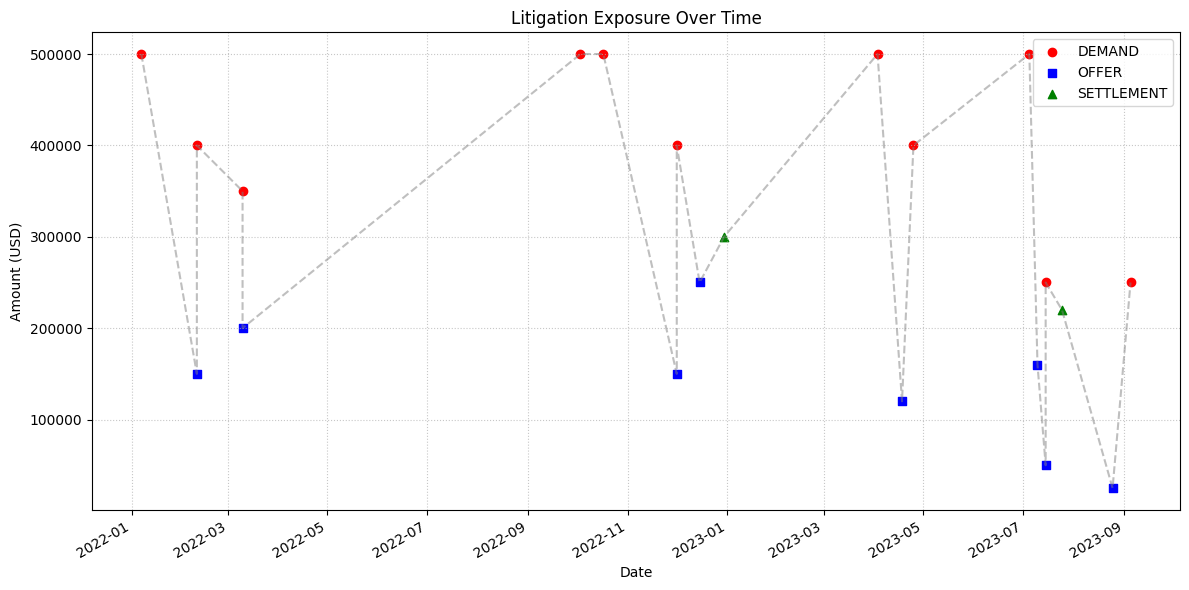

In [79]:
plot_litigation_summary(exposure_summary_updates)

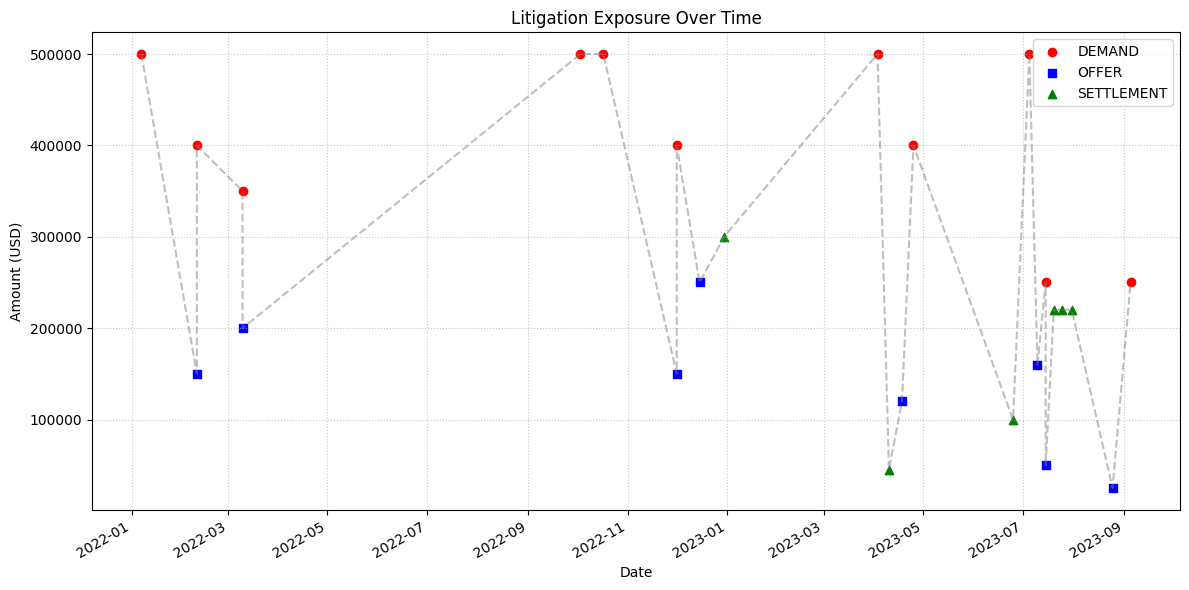

In [71]:
plot_litigation_summary(lit_amount_updates)

In [80]:
client = get_client()

all_notes = "\n".join(df['notes'].tolist())

response = client.chat.completions.create(
    model='gpt-4o',
    response_model=Iterable[ExposureAmountUpdate],
    max_retries=3,
    messages=[
        {
            "role": "system",
            "content": "You are a world class data extraction IA."
        },
        {
            "role": "user",
            "content": f"Extract the information from the following text. Make sure to follow the correct format. TEXT: {all_notes}",
        }
    ]
)

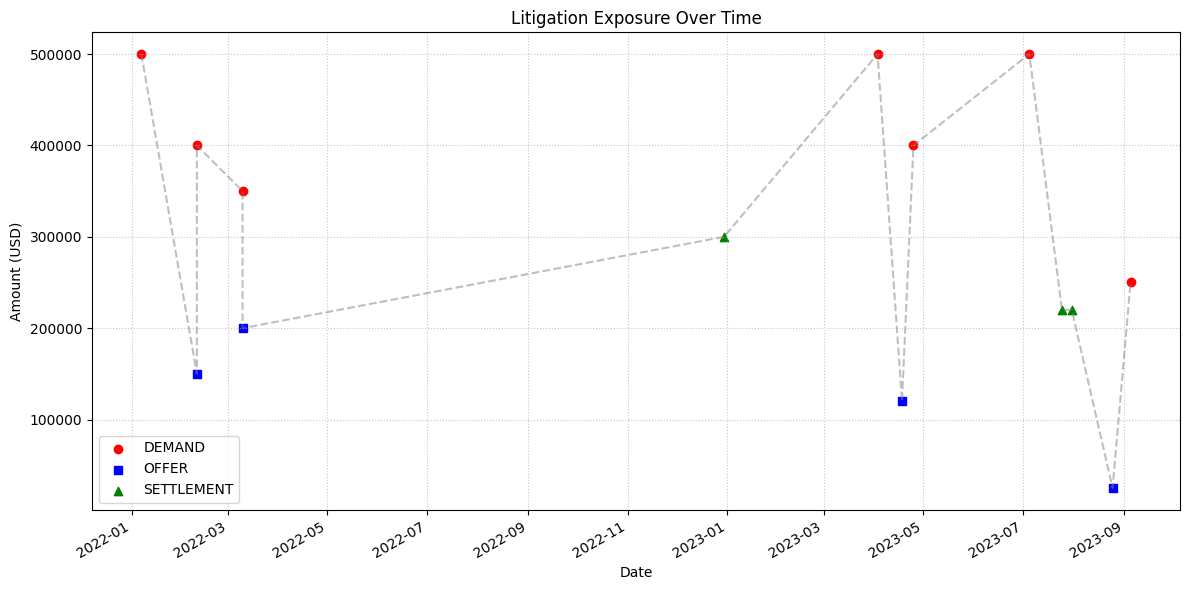

In [81]:
plot_litigation_summary(response)

In [83]:
count_tokens(all_notes)

4168

In [ ]:
import math

def sin_of_pi() -> int:
    result = math.sin(math.pi)
    return int(result)

In [ ]:
sin_of_pi()

0